In [1]:
import ROOT
import uproot
import numpy as np
import array as array
import math
import matplotlib.pyplot as plt
import pickle as pkl
import hist
#import statistics as st
ROOT.gStyle.SetOptStat(000000)

Welcome to JupyROOT 6.28/02


In [2]:
with open("pkl_files/old_bins/june13/qjetmass_zjets_gen__all_syst.pkl", "rb") as f:
    output = pkl.load( f )

with open("pkl_files/old_bins/june13/qjetmass_zjets_reco.pkl", "rb") as f:
    output_data = pkl.load( f )

In [28]:
groomed = False
closure = False

In [29]:
if groomed:
    s_response = 'response_matrix_g'
    s_data = 'ptjet_mjet_g_reco'
else:
    s_response = 'response_matrix_u'
    s_data = 'ptjet_mjet_u_reco'
    
resp_hist = output[s_response][{'systematic':'nominal'}].project('ptgen', 'ptreco', 'mgen', 'mreco')
resp_hist

Hist(
  Variable([0, 170, 200, 260, 350, 460, 13000], name='ptgen', label='p_{T,RECO} (GeV)'),
  Variable([0, 170, 200, 260, 350, 460, 13000], name='ptreco', label='p_{T,RECO} (GeV)'),
  Variable([0, 20, 40, 60, 80, 100, 150, 200, 13000], name='mgen', label='Mass (GeV)'),
  Variable([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200, 6200, 13000], name='mreco', label='m_{RECO} (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=169426, variance=57906.3) (WeightedSum(value=169427, variance=57906.3) with flow)

In [30]:
bin_by_bin = True

In [31]:
ipt = 3
if not bin_by_bin:
    mresp_hist = resp_hist.project( 'mgen', 'mreco')
else:
    mresp_hist = resp_hist[ipt,:,:,:]
    mresp_hist.underflow = 0
    mresp_hist.overflow = 0
    mresp_hist = mresp_hist.project( 'mgen', 'mreco')
    

In [32]:
mgenbins = mresp_hist.axes['mgen']
mrecobins = mresp_hist.axes['mreco']

In [33]:
mgenbins

Variable([0, 20, 40, 60, 80, 100, 150, 200, 13000], name='mgen', label='Mass (GeV)')

In [34]:


nmgenbins = len(mgenbins.edges) - 1
nmrecobins = len(mrecobins.edges) - 1

In [35]:
mBinsReco = array.array('d', [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200, 6200, 13000])
mBinsGen =  array.array('d', [0, 20, 40, 60, 80, 100, 150, 200, 13000])

generatorBinning = ROOT.TUnfoldBinning("generator")
signalBinning = generatorBinning.AddBinning("signal") 
signalBinning.AddAxis("massgen",nmgenbins,mBinsGen,
                        False, # needed for fakes
                        False # overflow bin
                        )


detectorBinning = ROOT.TUnfoldBinning("detector") 
detectorDistribution=detectorBinning.AddBinning("detectordistribution")
detectorDistribution.AddAxis("mass",nmrecobins,mBinsReco,
                        False, # no underflow bin (not reconstructed)
                        False # overflow bin
                        )

True

In [36]:
M = ROOT.TUnfoldBinning.CreateHistogramOfMigrations(generatorBinning,detectorBinning,"M")

h = detectorBinning.CreateHistogram("h")

    
htrue = generatorBinning.CreateHistogram("htrue")

Warning in <TROOT::Append>: Replacing existing TH1: M (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: htrue (Potential memory leak).


In [37]:
M_np = mresp_hist.values()
M_error_np = mresp_hist.variances()**0.5
if closure:
    h_np = np.sum(M_np, axis = 0)
    h_error_np = np.sum(mresp_hist.variances(), axis = 0)**0.5
else:
    h_np = output_data[s_data].project('ptreco','mreco')[ipt,:]
    h_np.underflow = 0
    h_np.overflow = 0
    h_np = h_np.project('mreco').values()
    h_error_np  = h_np**0.5

htrue_np = np.sum(M_np, axis = 1 )
htrue_error_np = np.sum(mresp_hist.variances(), axis = 1)**0.5

In [38]:
for i in range(h_np.shape[0]):
    h.SetBinContent(i+1, h_np[i])
    h.SetBinError(i+1, h_error_np[i])
for j in range(htrue_np.shape[0]):
    htrue.SetBinContent(j+1, htrue_np[j])
    htrue.SetBinError(j+1, htrue_error_np[j])

In [39]:
for i in range(M_np.shape[0]):
    for j in range(M_np.shape[1]):
        M.SetBinContent(i+1, j+1, M_np[i,j])
        M.SetBinError(i+1, j+1, M_error_np[i,j])

In [40]:
h_np = np.sum(M_np, axis = 0)
htrue_np = np.sum(M_np, axis = 1 )



for i in range(M_np.shape[0]):
    for j in range(M_np.shape[1]):
        M.SetBinContent(i+1, j+1, M_np[i,j])
        M.SetBinError(i+1, j+1, M_error_np[i,j])

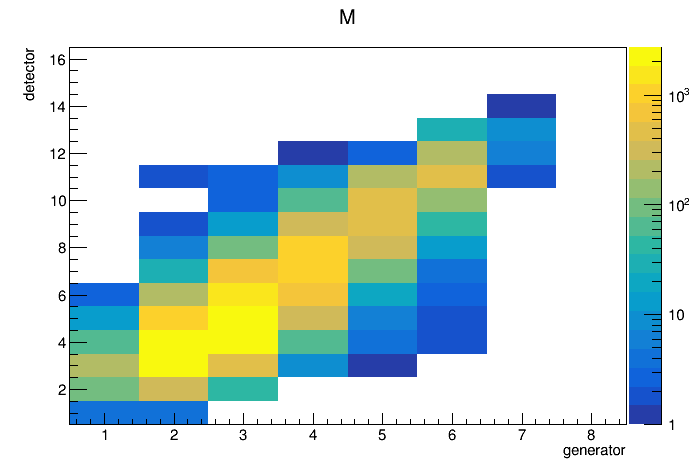

In [41]:
cM = ROOT.TCanvas()
M.Draw('colz')
cM.SetLogz()
cM.Draw()

In [46]:
import numpy as np
np.linalg.cond(M_np)

inf

In [43]:
M_np.shape

(8, 16)

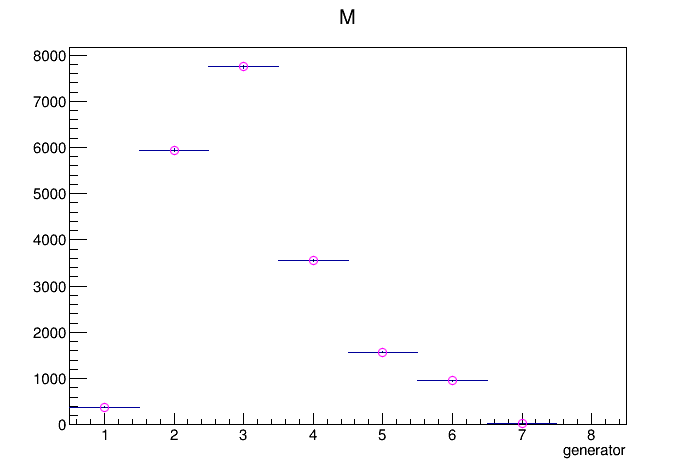

In [44]:
cP = ROOT.TCanvas()
proj_gen = M.ProjectionX()
proj_gen.Draw()
htrue.SetMarkerColor(4)
htrue.SetMarkerStyle(4)
htrue.SetMarkerSize(1)
htrue.SetMarkerColor(6)

htrue.Draw('same *')
cP.Draw()

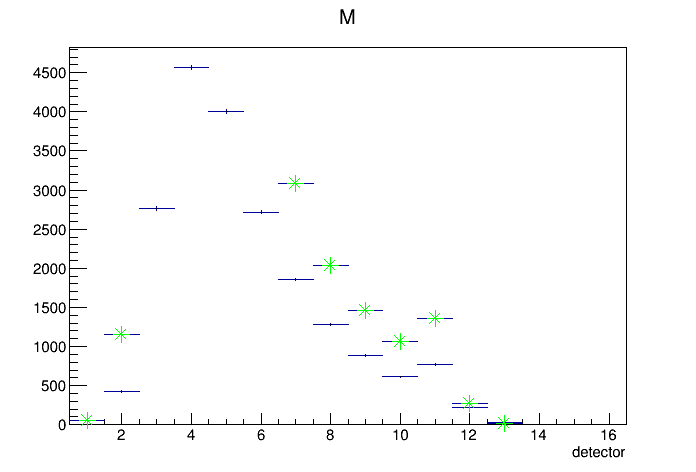

In [45]:
cP = ROOT.TCanvas()
proj_reco = M.ProjectionY()
proj_reco.Draw()
h.SetMarkerColor(3)
h.SetMarkerStyle(3)
h.SetMarkerSize(2)

h.Draw('same *')
cP.Draw()

In [73]:
orientation = ROOT.TUnfold.kHistMapOutputHoriz
regMode = ROOT.TUnfold.kRegModeCurvature
con = ROOT.TUnfold.kEConstraintArea #ROOT.TUnfold.kEConstraintArea
mode =  ROOT.TUnfoldDensity.kDensityModeBinWidth
axisSteering =  "*[b]"

u = ROOT.TUnfoldDensity(M, orientation, regMode, con, mode, generatorBinning, detectorBinning, "signal", axisSteering)



Info in <TUnfold::SetConstraint>: fConstraint=1
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 16 input bins and 8 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #9
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing signal regMode=3 densityMode=1 axisSteering=*[b]


In [74]:
u.SetInput( h )

3

Warning in <TUnfoldDensity::SetInput>: 3/16 input bins have zero error, and are ignored.


In [75]:
graph = ROOT.MakeNullPointer(ROOT.TGraph)
spline = ROOT.MakeNullPointer(ROOT.TSpline)
#u.DoUnfold(0.0)
u.ScanTau(50,0,0,spline)
#u.ScanLcurve(50, 0, 0,graph)

46

Info in <TUnfoldDensity::ScanTau>: logtau=-Infinity y=0.627350 X=1.902298 Y=0.028356
Info in <TUnfoldDensity::ScanTau>: logtau=0.954486 y=0.608890 X=1.913861 Y=0.005675
Info in <TUnfoldDensity::ScanTay>: logtau=0.454486 y=0.625457 X=1.902424 Y=0.026008
Info in <TUnfoldDensity::ScanTau>: logtau=0.704486 y=0.621400 X=1.903539 Y=0.020992
Info in <TUnfoldDensity::ScanTau>: logtau=0.579486 y=0.623991 X=1.902695 Y=0.024192
Info in <TUnfoldDensity::ScanTau>: logtau=0.829486 y=0.616840 X=1.906127 Y=0.015387
Info in <TUnfoldDensity::ScanTau>: logtau=0.516986 y=0.624828 X=1.902522 Y=0.025228
Info in <TUnfoldDensity::ScanTau>: logtau=0.641986 y=0.622878 X=1.903001 Y=0.022817
Info in <TUnfoldDensity::ScanTau>: logtau=0.766986 y=0.619438 X=1.904482 Y=0.018577
Info in <TUnfoldDensity::ScanTau>: logtau=0.891986 y=0.613408 X=1.908977 Y=0.011186
Info in <TUnfoldDensity::ScanTau>: logtau=0.485736 y=0.625165 X=1.902466 Y=0.025646
Info in <TUnfoldDensity::ScanTau>: logtau=0.548236 y=0.624440 X=1.902596 Y=

In [76]:
o_0 = u.GetOutput('output','Unfolded Mass for full p_{T} spectrum','signal','*', ROOT.kTRUE)

Error in <TUnfoldBinning::DecodeAxisSteering>: steering "*" does not end with [options]
Warning in <TROOT::Append>: Replacing existing TH1: output (Potential memory leak).
Error in <TUnfoldBinning::DecodeAxisSteering>: steering "*" does not end with [options]


In [77]:
%jsroot 

In [86]:
h2 = ROOT.TH1D('input', 'input', nmrecobins, mBinsReco)
for i in range(1, h2.GetNbinsX()+1):
    h2.SetBinContent(i, h.GetBinContent(i))
    
h2 = h2.Rebin(2)

cO = ROOT.TCanvas()
o = o_0.Clone('Unfolded Mass for full p_{T} spectrum')
o.GetXaxis().SetTitle('Jet Mass (GeV)')
o.GetYaxis().SetTitle('Counts/Bin width')

htrue2 = o.Clone()
htrue2.Reset()
for i in range(1, o.GetNbinsX()+1):
    o.SetBinContent(i, o_0.GetBinContent(i)/mgenbins.widths[i-1])
    o.SetBinError(i, o_0.GetBinError(i)/mgenbins.widths[i-1])
    
    h2.SetBinContent(i, h2.GetBinContent(i)/mgenbins.widths[i-1])
    
    htrue2.SetBinContent(i, htrue.GetBinContent(i)/mgenbins.widths[i-1])
    htrue2.SetMarkerStyle(32)
    htrue2.SetMarkerColor(6)
    htrue2.SetLineColor(6)
    
    h2.SetMarkerStyle(3)
    h2.SetMarkerColor(2)
    h2.SetLineColor(2)
o.SetMarkerStyle(25)    
o.SetFillColor(0)
htrue2.Scale(o.Integral()/htrue2.Integral() )

o.Draw('same e') 
h2.Draw('same e')

legend = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend.AddEntry(o, 'Unfolded', 'pe')
legend.AddEntry(htrue2, 'Truth')
legend.AddEntry(h2, 'Input (Gen Binned)')
legend.Draw()
htrue2.Draw('same e')
htrue2.GetXaxis().SetRangeUser(0,200)
h2.GetXaxis().SetRangeUser(0,200)
o.GetXaxis().SetRangeUser(0,200)
cO.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: input (Potential memory leak).


In [79]:
error_M = u.GetEmatrixTotal('Covariance')
cE = ROOT.TCanvas()
error_M.Draw('colz')
error_M.GetXaxis().SetRangeUser(0,200)
error_M.GetYaxis().SetRangeUser(0,200)
cE.SetLogz()
cE.Draw()


Warning in <TROOT::Append>: Replacing existing TH1: Covariance (Potential memory leak).


In [80]:
o_0.GetBinError(2)

101.38923824663347

In [81]:
o_0.Integral()

37457.0

(0.0, 1000.0)

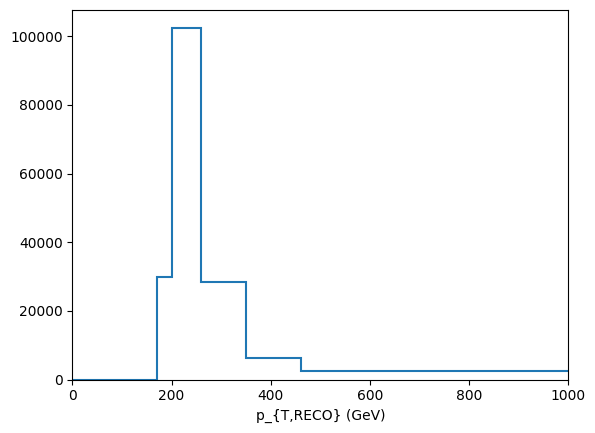

In [82]:
resp_hist.project('ptreco').plot()
plt.xlim(0,1000)